In [1]:

import os
from typing import Iterator
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics.cluster import contingency_matrix
from scipy.optimize import linear_sum_assignment
from scipy.stats import mode


In [2]:

SEED = 42
DATA_DIRECTORY = os.path.join('..', 'data')
DATASET_ROOTDIR = os.path.join(DATA_DIRECTORY, 'original')
DATASET_FILEPATH = os.path.join(DATASET_ROOTDIR, 'astral_40.sty')


In [ ]:
def parse_fasta(path: str) -> Iterator[SeqRecord]:
    return SeqIO.parse(path, "fasta")


def get_dataset() -> tuple[list[str], list[str]]:
    iterator = list(parse_fasta(DATASET_FILEPATH))

    return [str(x.seq) for x in iterator], [str(x.id) for x in iterator]


def kmers1(value: str) -> np.ndarray:
    char_count = 26
    base = ord("a")
    maps = [(ord(x) - base, ord(y) - base) for (x, y) in zip(value[:-1], value[1:])]
    matrix = np.zeros((char_count, char_count))

    for (x, y) in maps:
        matrix[x][y] = 1

    return matrix.flatten()


def kmers2(value: str) -> np.ndarray:
    char_count = 26

    base = ord('a')

    values = zip(value[:-4], value[1:-3], value[4:-1], value[5:])

    maps = [((ord(x1) - base) * char_count + ord(x2) - base, (ord(y1) - base) * char_count + ord(y2) - base) for (x1, x2, y1, y2) in values]

    matrix = np.zeros((26**2, 26**2))
    for (x, y) in maps:
        matrix[x][y] = 1

    return matrix.flatten()

kmers = kmers2

In [ ]:

import json

if os.path.exists('../data/normalized/pca_normalized.json'):
    with open('../data/normalized/pca_normalized.json', 'r') as f:
        x = json.load(f)
        X_normalized = np.array(list(map(lambda x: np.array(x), x)))

In [10]:
from math import ceil
from sklearn.decomposition import IncrementalPCA
from sklearn.discriminant_analysis import StandardScaler

def chunk(data, chunk_size):
    """Yield successive n-sized chunks from data."""
    for i in range(0, len(data), chunk_size):
        yield data[i:i + chunk_size]


X, Y = get_dataset()

if not os.path.exists('../data/normalized/pca_normalized.json'):

    CHUNCK_SIZE = 300
    CHUNCK_COUNT = ceil(len(X) / CHUNCK_SIZE)

    # Fit scaler

    print("Fitting scaler...")
    scaler = StandardScaler()
    for i, chunck in enumerate(chunk(X, CHUNCK_SIZE)):
        print(f"Chunck {i}/{CHUNCK_COUNT}")
        chunck = [kmers(x) for x in chunck]
        scaler.partial_fit(chunck)


    # Fit PCA

    print("Fitting PCA...")
    pca = IncrementalPCA(n_components=300, batch_size=CHUNCK_SIZE)
    for i, chunck in enumerate(chunk(X, CHUNCK_SIZE)):
        print(f"Chunck {i}/{CHUNCK_COUNT}")
        chunck = [kmers(x) for x in chunck]
        X_scaled = scaler.transform(chunck)
        pca.partial_fit(X_scaled)


    # Normalize

    print("Reducing dimensions...")
    X_normalized = []
    for i, chunck in enumerate(chunk(X, CHUNCK_SIZE)):
        print(f"Chunck {i}/{CHUNCK_COUNT}")
        chunck = [kmers(x) for x in chunck]
        X_scaled = scaler.transform(chunck)
        X_reduced_chuck = pca.transform(X_scaled)
        X_normalized.extend(X_reduced_chuck)


    print(X_normalized)

    # pca.fit(X_normalized)
    # X_normalized = pca.fit_transform(X_normalized)

X_train, X_test, Y_train, Y_test = train_test_split(
    X_normalized, Y,
    train_size=0.7,
    random_state=42,
    shuffle=True)

In [11]:
import json


if not os.path.exists('../data/normalized/pca_normalized.json'):
    l = list(map(lambda x: x.tolist(), X_normalized))

    json_string = json.dumps(l, separators=(",", ":"))

    os.makedirs('../data/normalized', exist_ok=True)
    with open('../data/normalized/pca_normalized.json', 'w') as f:
        f.write(json_string)

In [32]:
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, f1_score, silhouette_score

kmeans_scores = {
    "inertias": [],
    "silhouettes": [],
    "calinskis": [],
    "davies": []
}

kmeans_cluster_range = range(2, 10000, 500)

for i in kmeans_cluster_range:
    print(i)
    kmeans = KMeans(n_clusters=i, random_state=SEED)
    kmeans.fit(X_train)
    labels = kmeans.labels_
    kmeans_scores["inertias"].append(kmeans.inertia_)
    kmeans_scores['silhouettes'].append(silhouette_score(X_train, labels, random_state=SEED))
    kmeans_scores["calinskis"].append(calinski_harabasz_score(X_train, labels))
    kmeans_scores["davies"].append(davies_bouldin_score(X_train, labels))

2
502
1002
1502
2002
2502
3002
3502
4002
4502
5002
5502
6002
6502
7002
7502
8002
8502
9002
9502


In [ ]:
# import itertools
import itertools
from sklearn.cluster import DBSCAN
from sklearn.metrics import davies_bouldin_score

dbscan_scores = {
    "davies": [],
    "calinskis": [],
    "values": []
}

eps_range = list(range(1, 100, 10))
range_values = list(range(3, 10000, 1000))

dbscan_cluster_range = itertools.product(range_values, range_values)
# dbscan_cluster_range = []

for (x, y) in dbscan_cluster_range:
    print(x, y)
    dbscan = DBSCAN(eps=x, min_samples=y)
    labels = dbscan.fit_predict(X_train)

    mask_clustered = (labels != -1)
    X_clean = X_train[mask_clustered]
    labels_clean = labels[mask_clustered]

    v = list(filter(lambda x: x not in (0, 1), np.unique(labels_clean)))

    if (len(v) != 0):
        dbscan_scores['values'].append((i, v))

    dbscan_scores["davies"].append(
        davies_bouldin_score(X_clean, labels_clean)
    )

    dbscan_scores["calinskis"].append(calinski_harabasz_score(X_train, labels))

if len(dbscan_scores['values']) == 0:
    print("Nenhum cluster encontrado pelo DBSCAN.")


3 3
3 1003
3 2003
3 3003
3 4003
3 5003
3 6003
3 7003
3 8003
3 9003
1003 3
1003 1003
1003 2003
1003 3003
1003 4003
1003 5003
1003 6003
1003 7003
1003 8003
1003 9003
2003 3
2003 1003
2003 2003
2003 3003
2003 4003
2003 5003
2003 6003
2003 7003
2003 8003
2003 9003
3003 3
3003 1003
3003 2003
3003 3003
3003 4003
3003 5003
3003 6003
3003 7003
3003 8003
3003 9003
4003 3
4003 1003
4003 2003
4003 3003
4003 4003
4003 5003
4003 6003
4003 7003
4003 8003
4003 9003
5003 3
5003 1003
5003 2003
5003 3003
5003 4003
5003 5003
5003 6003
5003 7003
5003 8003
5003 9003
6003 3
6003 1003
6003 2003
6003 3003
6003 4003
6003 5003
6003 6003
6003 7003
6003 8003
6003 9003
7003 3
7003 1003
7003 2003
7003 3003
7003 4003
7003 5003
7003 6003
7003 7003
7003 8003
7003 9003
8003 3
8003 1003
8003 2003
8003 3003
8003 4003
8003 5003
8003 6003
8003 7003
8003 8003
8003 9003
9003 3
9003 1003
9003 2003
9003 3003
9003 4003
9003 5003
9003 6003
9003 7003
9003 8003
9003 9003
[]


In [36]:
from sklearn.cluster import AgglomerativeClustering

hierarchy_scores = {
    "davies": [],
    "calinski": [],
    "silhouette": []
}

hierarchy_cluster_range = range(2, 10000, 500)

for i in hierarchy_cluster_range:
    print(i)
    hac = AgglomerativeClustering(
        n_clusters=i,
        metric="euclidean",
        linkage="ward"
    )

    cluster_labels = hac.fit_predict(X_train)

    hierarchy_scores["silhouette"].append(
        silhouette_score(X_train, cluster_labels)
    )
    hierarchy_scores["calinski"].append(
        calinski_harabasz_score(X_train, cluster_labels)
    )
    hierarchy_scores["davies"].append(
        davies_bouldin_score(X_train, cluster_labels)
    )

print(hierarchy_scores)

2
502
1002
1502
2002
2502
3002
3502
4002
4502
5002
5502
6002
6502
7002
7502
8002
8502
9002
9502
{'davies': [0.031190413295450938, 0.610564010034743, 0.8511303378324617, 0.9221465008178066, 0.9371539588338831, 0.9379426364693019, 0.9193083716545822, 0.8852883749742769, 0.8491465832560131, 0.8072117047099279, 0.7681836869445373, 0.7411313696893701, 0.7079818757083017, 0.6760719938865919, 0.6401246023054052, 0.6129102655276799, 0.5744345622047514, 0.5472836485335997, 0.5019514144834085, 0.4516902654476632], 'calinski': [128.84631111773444, 478.93530133740273, 347.2297558121346, 282.3826128264282, 245.12132605741792, 221.67629063661758, 205.70012509720905, 194.65307541327576, 187.07297743817014, 181.81284021116664, 178.45011843428722, 176.62218261862964, 176.21407142964293, 177.18742909953383, 179.4858041491916, 183.60600897198674, 189.93480120098602, 199.20946585860545, 213.61703412306605, 237.48035553792482], 'silhouette': [0.9490468792376747, -0.041748422826259506, -0.08879461690069464,

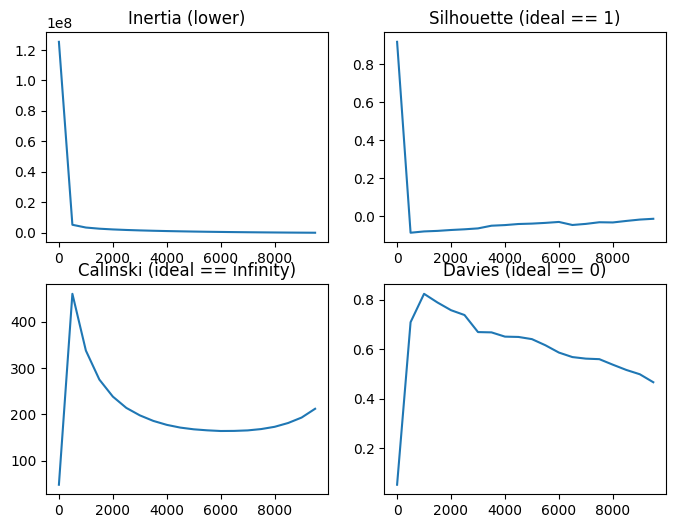

In [35]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6))  # 2x2 grid

axes[0, 0].set_title("Inertia (lower)")
axes[0, 0].plot(kmeans_cluster_range, kmeans_scores["inertias"])

axes[0, 1].set_title("Silhouette (ideal == 1)")
axes[0, 1].plot(kmeans_cluster_range, kmeans_scores['silhouettes'])

axes[1, 0].set_title("Calinski (ideal == infinity)")
axes[1, 0].plot(kmeans_cluster_range, kmeans_scores["calinskis"])

axes[1, 1].set_title("Davies (ideal == 0)")
axes[1, 1].plot(kmeans_cluster_range, kmeans_scores["davies"])

plt.show()

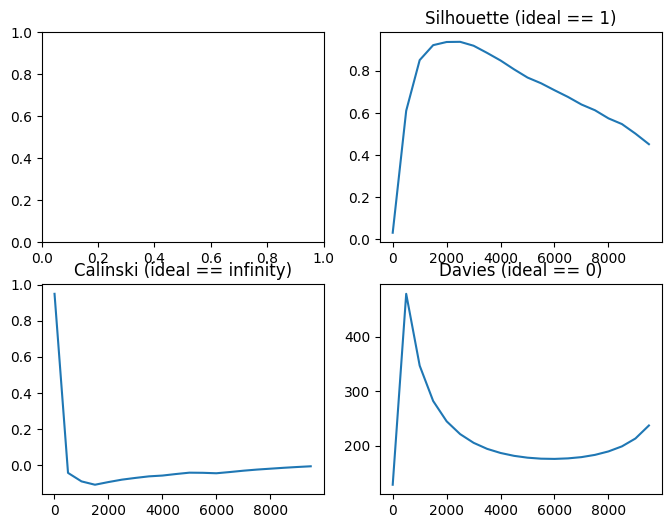

In [37]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6))  # 2x2 grid

axes[0, 1].set_title("Silhouette (ideal == 1)")
axes[0, 1].plot(hierarchy_cluster_range, hierarchy_scores["davies"])

axes[1, 0].set_title("Calinski (ideal == infinity)")
axes[1, 0].plot(hierarchy_cluster_range, hierarchy_scores["silhouette"])

axes[1, 1].set_title("Davies (ideal == 0)")
axes[1, 1].plot(hierarchy_cluster_range, hierarchy_scores["calinski"])

plt.show()